### Preprocessamento

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.mlab import psd
from matplotlib import rcParams, cm

from scipy import signal
from scipy.signal import stft
from scipy.signal import welch

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data = np.load('data.npy')

num_subjects = 10  # quantidade de voluntários
num_trials = 3     # quantidade de tentativas
num_classes = 8    # quantidade de tipos diferentes de movimentos
num_channels = 4   # quantidade de canais/eletrodos
num_samples = 1600 # quantidade de amostras

O objetivo é definir um step que alcance um resultado de janelas semelhantes entre o domínio do tempo e o domínio da frequência.

Obter os dados no domínio da frequência pelo método Welch, casando também o tamanho da dimensionalidade até o número de janelas.

In [2]:
step = 47    # é o passo de deslocamento entre as janelas consecutivas
segment = 64 # define o tamanho da janela no domínio do tempo

data = data.reshape(num_subjects, num_trials * num_classes, num_channels, num_samples) # (10, 24, 4, 1600)

n_win = int((data.shape[-1] - segment) / step) + 1 # 33
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:, :, :, k:(k + segment)] for k in ids]).transpose(1, 2, 3, 0, 4)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=64, noverlap=32)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (voluntario, classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (voluntario, classes+ensaios, canais, janelas, linhas)')

Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (10, 24, 4, 33, 64) - (voluntario, classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (10, 24, 4, 33, 51) - (voluntario, classes+ensaios, canais, janelas, linhas)


In [3]:
# Calcula o espectrograma usando o método de Welch   
f, Pxx = welch(data, fs=200, nperseg=64, noverlap=32)

print('Formato (shape) dos dados no domínio da frequência usando o método Welch:')           
print(f'Domínio da frequência: {Pxx.shape} - (voluntário, classes+ensaios, canais, janelas)')

Formato (shape) dos dados no domínio da frequência usando o método Welch:
Domínio da frequência: (10, 24, 4, 33) - (voluntário, classes+ensaios, canais, janelas)


## Features

Definição das funções de extração de características.

In [4]:
sample_rate = 200

# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

# Domínio do Tempo
def wamp(x, threshold=0):
    result = 0
    N = x.shape[-1]

    for i in range(0, N-1):
        diff = np.abs(x[:,:, :, :, i+1] - x[:,:, :, :, i])
        result += np.where(diff > threshold, 1, 0)  

    return result

def wl(x):
    result = 0
    N = x.shape[-1]

    for i in range(0,N-1):
        result += np.abs(x[:,:, :, :, i] - x[:,:, :, :, i+1])
    
    return result

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def zc(x):
    N = x.shape[-1]
    result = 0
    
    for i in range(N-1):
        result += np.where(x[:,:, :,:,i] * x[:,:,:,:,i+1] <= 0, 1, 0)
    
    return result

## Domínio da Frequência
def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

# Função auxiliar para fmn
def fj(M, j):
    return j * sample_rate / 2 * M

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def fmn(w):
    mean_freq_list = []
    for i in range(w.shape[0]):
        _, _, _, M = w[i].shape
        f_j = (np.arange(1, M+1) * 200) / (2 * M)
        weighted_sum = np.sum(f_j * PSD(w[i]))
        mean_freq = weighted_sum / fmd(w[i]) * 2
        mean_freq_list.append(mean_freq)
    return mean_freq_list

def mmnf(w):
    mean_freq_list = []
    for i in range(w.shape[0]):
        _, _, _, M = w[i].shape
        f_j = np.arange(1, M+1) * 200 / (2 * M)
        weighted_sum = np.sum(f_j * np.abs(w[i]), axis=-1)
        mean_freq = weighted_sum / mmdf(w[i]) * 2
        mean_freq_list.append(mean_freq)
    return mean_freq_list

In [5]:
final_data = list()

final_data.append(var(chunks_time))
final_data.append(wamp(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(zc(chunks_time))

# Função implementadas por outros alunos (desconsiderar)
# final_data.append(log_det(chunks_time))

# Adiciona características no domínio da frequencia
final_data.append(fmd(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(mmnf(chunks_freq))

# Adiciona resultado (característica) do Welch 
final_data.append(Pxx)
final = np.array(final_data)

final_reshaped = final.transpose((1, 0, 3, 2, 4))

dim1 = final_reshaped.shape[1]
dim2 = final_reshaped.shape[2]
final_concatenated = final_reshaped.reshape((10, dim1 * dim2, 24, 33))

dim3 = final_concatenated.shape[2]
dim4 = final_concatenated.shape[3]
final_concatenated = final_concatenated.reshape((10, dim1 * dim2, dim3 * dim4))

print(final_concatenated.shape, "(Voluntários, Características * canais, classes + ensaios * janelas)")

final_concatenated = np.swapaxes(final_concatenated, 1, 2)

# itera sobre cada um dos voluntarios
for i in range(final_concatenated.shape[0]):  
    
    # Salvar o conteúdo do voluntário em um arquivo
    # cada um dos arquivos terá o shape (40, 792)
    np.save(f'resultados_voluntario_{i}.npy', final_concatenated[i, :, :]) 

(10, 40, 792) (Voluntários, Características * canais, classes + ensaios * janelas)


## Tarefa 4

In [6]:
movements = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']

subjects = {}

subjects = {i: np.load(f'resultados_voluntario_{i}.npy') for i in range(final_concatenated.shape[0])}

### Visualização dos dados

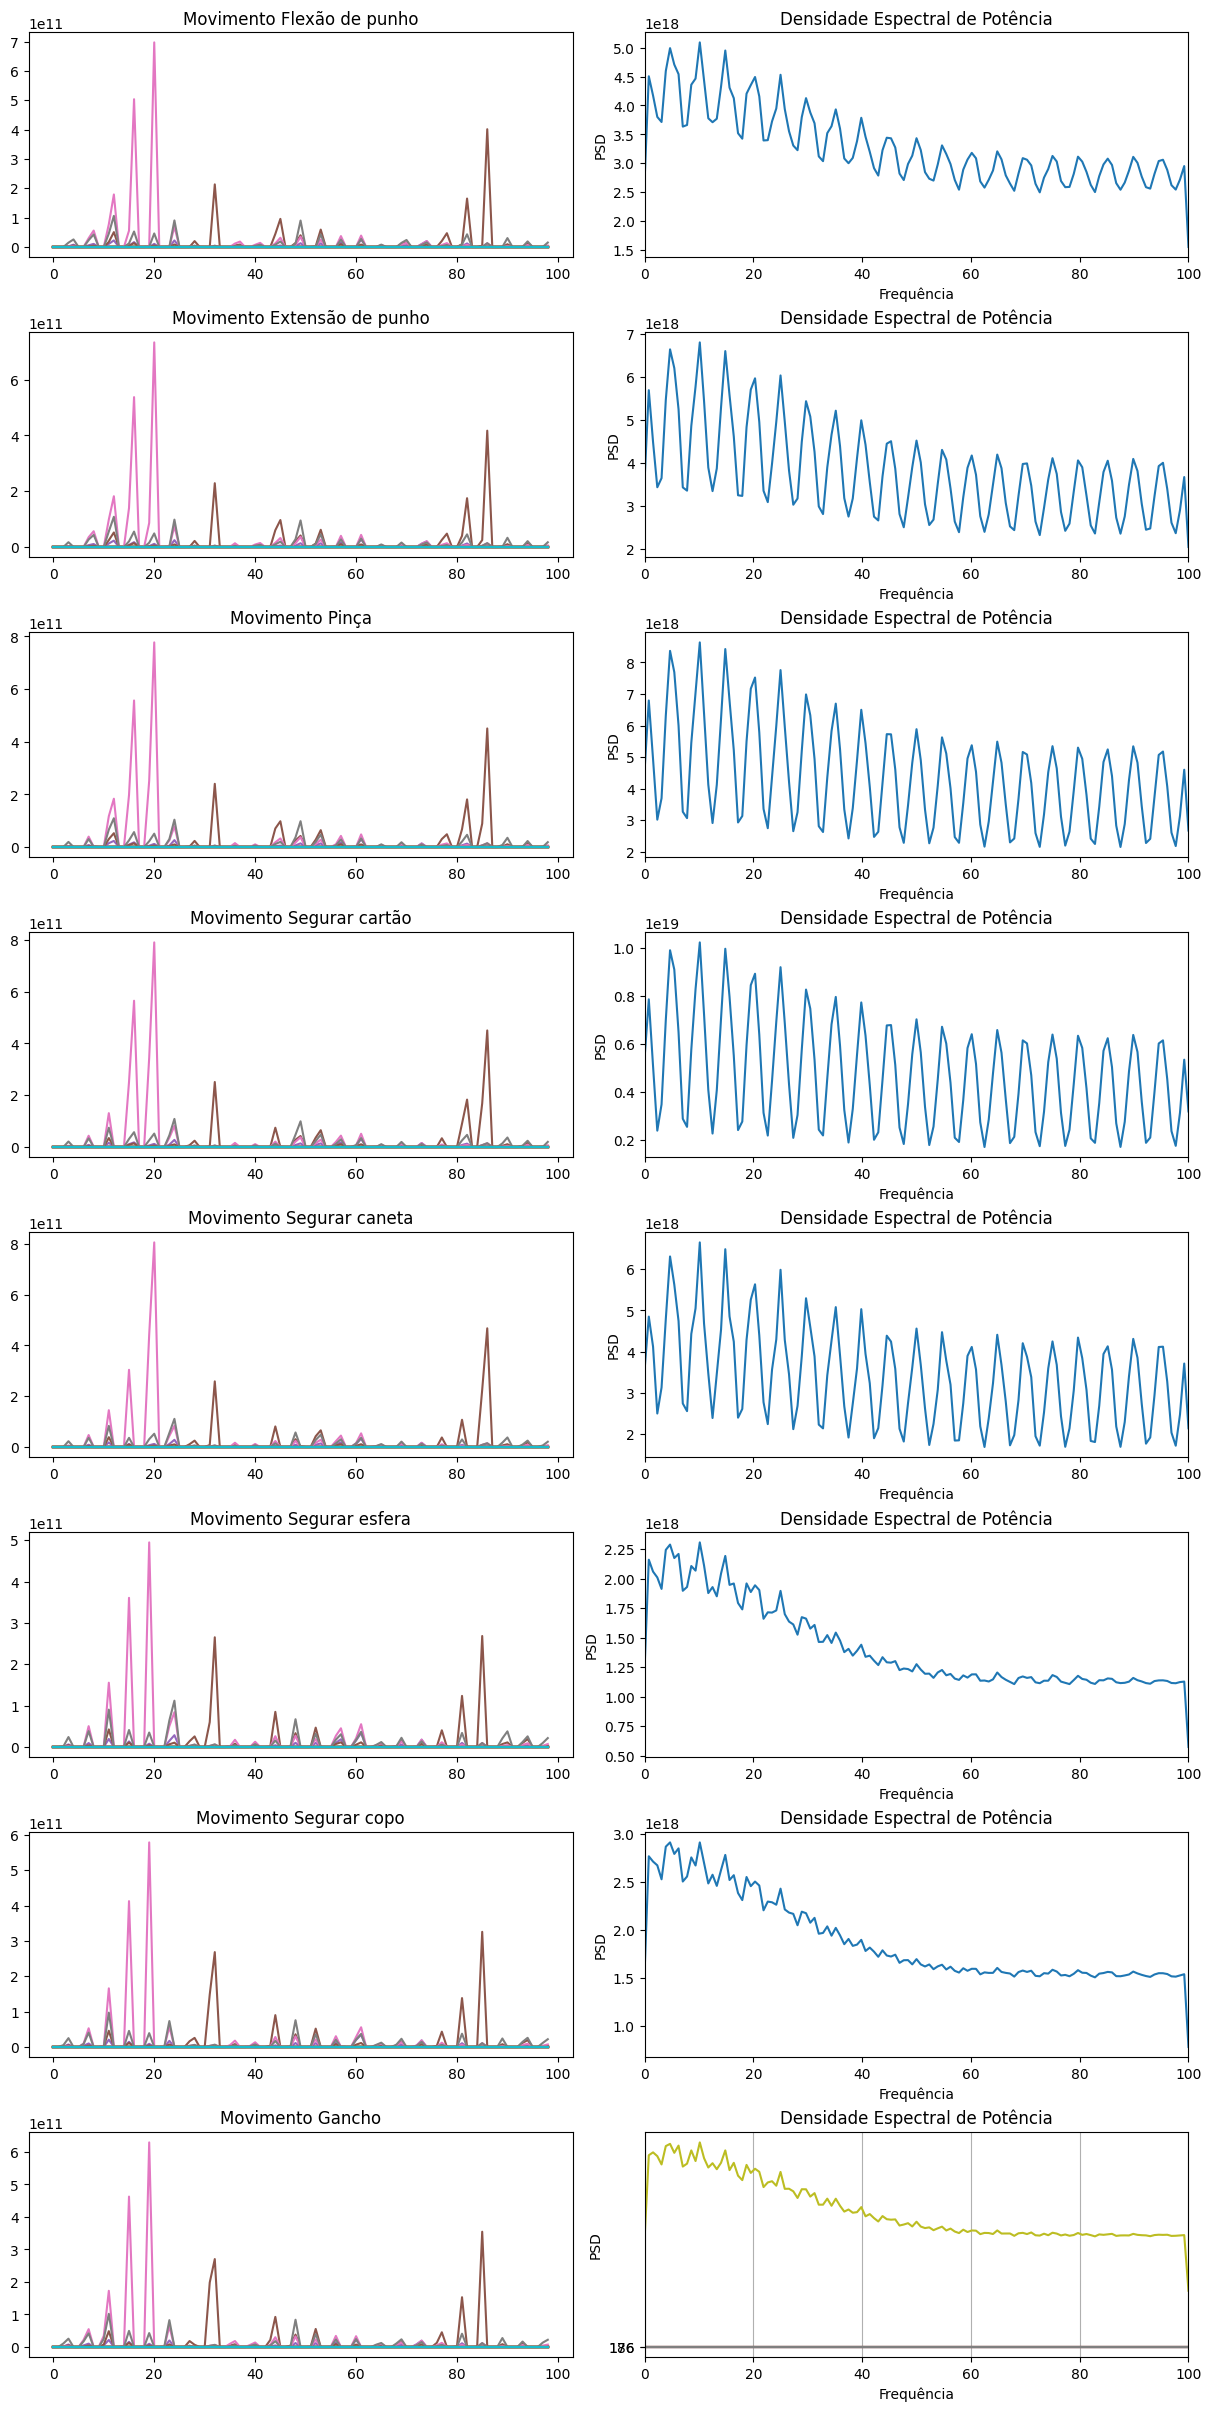

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num_subject = 7
subject = subjects[num_subject]
num_subplts = len(movements)

fig, ax = plt.subplots(num_subplts, 2, constrained_layout=True)
ax = ax if num_subplts > 1 else [ax]

fig.set_figheight(3.0 * num_subplts)
fig.set_figwidth(12.0)

for i in range(num_subplts):
    data = np.array([subject[e, :] for e in range(i, subject.shape[0], 8)])
    
    ax[i, 0].set_title(f'Movimento {movements[i]}')
    ax[i, 0].plot(data)
    
    psd, freqs = plt.psd(data.flatten(), Fs=200) 
    
    ax[i, 1].plot(freqs, psd)
    
    ax[i, 1].set_xlim(0, max(freqs))
    
    ax[i, 1].set_xlabel('Frequência')
    ax[i, 1].set_ylabel('PSD')
    ax[i, 1].set_title('Densidade Espectral de Potência')

plt.show()

## Métodos de seleção automatizada de característica

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

num_movements = len(movements) ## 8 movimentos
num_samples_per_movement = subject.shape[0] // num_movements ## 99
y = [[str(i)] * num_samples_per_movement for i in range(1, num_movements + 1)]
y = np.array(y).flatten()


## Normalização dos dados
scaler = StandardScaler()
X = scaler.fit_transform(subject)


## VarianceThreshold
selector = VarianceThreshold()
X_new = selector.fit_transform(X)


## RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)  

selector = SelectFromModel(estimator, threshold=0)
X_new = selector.fit_transform(X_new, y)
X_new.shape

(792, 36)

### Teste simples de classificação por SVM

In [17]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Carregar os conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=2)

# Criando o classificador SVM
svm_classifier = svm.SVC()

# Treinando o modelo SVM com os dados de treinamento
svm_classifier.fit(X_train, y_train)

# Realizando previsões nos dados de teste
y_pred = svm_classifier.predict(X_test)

# Calculando a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)

print("Resultados Iniciais (SVM)")
print(classification_report(y_test, y_pred, target_names=movements))


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1, 10]
}

# Criar o classificador SVM
svm_classifier = SVC()

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=10)

# Treinar o modelo com a busca em grade
grid_search.fit(X_new, y)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Realizar previsões nos dados de teste
y_pred = best_model.predict(X_test)



# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)

print("Resultados após Tunning do modelo (GridSearchCV)")
print(classification_report(y_test, y_pred, target_names=movements))

Resultados Iniciais (SVM)
                   precision    recall  f1-score   support

  Flexão de punho       0.90      0.56      0.69        16
Extensão de punho       0.73      0.73      0.73        22
            Pinça       0.57      0.50      0.53        16
   Segurar cartão       0.41      0.60      0.49        15
   Segurar caneta       0.65      0.65      0.65        23
   Segurar esfera       0.79      0.58      0.67        26
     Segurar copo       0.74      0.77      0.76        22
           Gancho       0.62      0.84      0.71        19

         accuracy                           0.66       159
        macro avg       0.68      0.65      0.65       159
     weighted avg       0.69      0.66      0.66       159

Resultados após Tunning do modelo (GridSearchCV)
                   precision    recall  f1-score   support

  Flexão de punho       0.89      1.00      0.94        16
Extensão de punho       0.84      0.95      0.89        22
            Pinça       0.93      0.